In [1]:
import numpy as np
import pandas as pd   
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
df = pd.read_csv("Data/data_pre.csv")
df = df.dropna()
df = df.drop(columns=['Unnamed: 0','CARRIER_DELAY'])

In [3]:
y = df.DEP_DELAY
dates = df.FL_DATE
X = df.drop(["DEP_DELAY"],axis=1)
X["FL_DATE"] = pd.to_datetime(X["FL_DATE"]).dt.dayofyear
# Convert DEP_TIME to integer hour
X["DEP_TIME"] = pd.to_datetime(X["DEP_TIME"]).dt.hour
X


,FL_DATE,DEP_TIME,TAXI_OUT,TEMP,WIND,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_US,OP_CARRIER_United Airlines
0,1,22,18.0,34.7,12.4,0,0,0,1,0,0,0,0,0,0
10,1,15,18.0,38.7,13.2,0,0,0,1,0,0,0,0,0,0
15,1,11,29.0,36.7,13.1,0,0,0,1,0,0,0,0,0,0
20,1,13,27.0,38.4,13.2,0,0,0,0,0,0,0,1,0,0
22,1,20,57.0,35.7,13.0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54152,181,8,31.0,73.1,9.3,0,0,0,0,0,0,0,1,0,0
54153,181,21,30.0,71.8,9.6,0,0,0,0,0,0,0,1,0,0
54155,181,9,16.0,75.0,9.7,0,0,0,0,0,0,0,1,0,0
54157,181,15,34.0,78.6,13.7,0,0,0,0,0,0,0,1,0,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# standardize input features
#X_train_mean = X_train.mean(axis=0)
#X_train_std = X_train.std(axis=0)
#X_train = (X_train - X_train_mean) / X_train_std

#X_test_mean = X_test.mean(axis=0)
#X_test_std = X_test.std(axis=0)
#X_test = (X_test - X_test_mean) / X_test_std

# standardize target
#y_train_mean = y_train.mean()
#y_train_std = y_train.std()
#y_train = (y_train - y_train_mean) / y_train_std

#y_test_mean = y_test.mean()
#y_test_std = y_test.std()
#y_test = (y_test - y_test_mean) / y_test_std


In [5]:
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 7270
num test: 3582


In [6]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

REALLY bad model

First a model with TAXI_OUT, DESTINATION and ORIGIN as inpot with same regression coefficients

In [7]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [8]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train.to_numpy()[:1000,:]).float()
y_train_small = torch.tensor(y_train.to_numpy()[:1000]).float()

In [9]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()


Sample: 100%|██████████| 1200/1200 [05:37,  3.56it/s, step size=4.13e-02, acc. prob=0.934]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.04      0.03      0.04     -0.01      0.09    882.75      1.00
   beta[0]      0.17      0.11      0.17     -0.03      0.32    549.87      1.00
   beta[1]      0.19      0.03      0.19      0.14      0.24    841.38      1.00
   beta[2]     -0.27      0.03     -0.27     -0.32     -0.21   1022.35      1.00
   beta[3]     -0.23      0.11     -0.23     -0.39     -0.04    602.02      1.00
   beta[4]     -0.17      0.03     -0.17     -0.22     -0.11    670.00      1.00
   beta[5]      0.07      0.34      0.10     -0.46      0.65    131.57      1.00
   beta[6]      0.01      0.45      0.04     -0.72      0.78    129.96      1.00
   beta[7]      0.02      0.10      0.03     -0.15      0.19    133.31      1.00
   beta[8]     -0.05      0.31     -0.03     -0.57      0.44    131.74      1.00
   beta[9]     -0.03      0.08     -0.02     -0.15      0.10    143.33      1.00
  beta[10]     -0.05      0

In [10]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test.to_numpy(), posterior_samples["beta"].numpy().T), axis=1)

# Convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.383
MAE: 41.784
RMSE: 57.186
R2: 0.146


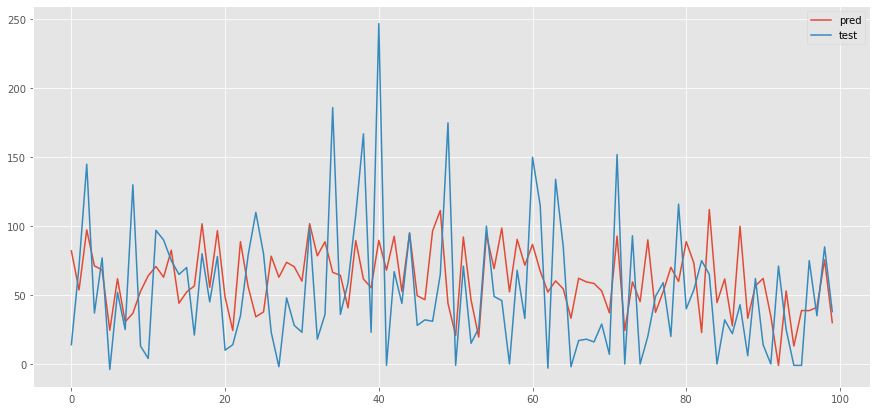

In [40]:
y_true = y_true.reset_index().drop('index',axis=1)
fig = plt.subplots(1,figsize=(15,7))
plt.plot(preds[:100],label='pred')
plt.plot(y_true[:100],label='test')
plt.legend()